# TWSQ Research Paper: Kelile Southwell
## Correlated Pairs Trading (Training Set)

1. Get data on returns for TRAINING SET

In [212]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 

client = bnb_client(tld='US')

def get_binance_px(symbol,freq,start_ts = '2023-07-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

#these are all of the coins I could find on binance whose data is accessible for USDT and USDC
univ = ['BTCUSDC', 'BTCUSDT', 
        'ETHUSDC', 'ETHUSDT', 
        'SOLUSDC', 'SOLUSDT', 
        'ADAUSDC', 'ADAUSDT',
        'XRPUSDT', 'XRPUSD', 
        'AVAXUSDT', 'AVAXUSD',
        'BNBUSDT', 'BNBUSD', 
        'DOGEUSDT', 'DOGEUSD',
        'SUIUSDT', 'SUIUSD',
        'BCHUSDT', 'BCHUSD',
        'LTCUSDT', 'LTCUSD',
        'SHIBUSDT', 'SHIBUSD',
        'DOTUSDT', 'DOTUSDT',
        'PEPEUSDT', 'PEPEUSD',
        'AAVEUSDT', 'AAVEUSD',
        'UNIUSDT', 'UNIUSD',
        'LINKUSDT', 'LINKUSD',
        'HBARUSDT', 'HBARUSD',
        'XLMUSDT', 'XLMUSD']

freq = '1h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18279/1871289501.py:16: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18279/1871289501.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18279/1871289501.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed 

In [213]:
ret_train = ret["2023-07-01":"2024-07-02"]

In [214]:
all_coins = client.get_all_tickers()
all_coins = pd.DataFrame(data=all_coins)
all_coins[all_coins['symbol'].str.startswith('LTC')]

,symbol,price
4,LTCUSD4,96.2100
10,LTCUSDT,107.97000000
16,LTCBTC,0.00090100
356,LTCUSD,107.85000000


2. Getting cumulative returns

In [215]:
#basic cumulative returns formula
cumret_train = ret_train.fillna(0).add(1).cumprod().subtract(1)

4. Perform linear regressions to find betas between pairs (will use later for signal generation)

In [216]:
import statsmodels.api as sm

all_pair_betas = pd.DataFrame(index=["betas"])
processed_pairs = set()
#generating betas for each pair with nested for loops
for crypto1 in cumret_train.columns:
    for crypto2 in cumret_train.columns:
        if crypto1 != crypto2 and crypto1[:4] == crypto2[:4]:
            # Normalize the pair so that the order doesn't matter (alphabetically sorted)
            pair = tuple(sorted([crypto1, crypto2]))
            
            # Skip the pair if it has already been processed
            if pair in processed_pairs:
                continue
            
            # Mark the pair as processed
            processed_pairs.add(pair)

            model = sm.OLS(cumret_train[crypto2], cumret_train[crypto1]).fit()
            beta_value = model.params[crypto1]

            pair_name = f"{crypto1}/{crypto2}"
            all_pair_betas[pair_name] = [beta_value] 

all_pair_betas

,BTCUSDC/BTCUSDT,ETHUSDC/ETHUSDT,SOLUSDC/SOLUSDT,ADAUSDC/ADAUSDT,XRPUSDT/XRPUSD,AVAXUSDT/AVAXUSD,BNBUSDT/BNBUSD,DOGEUSDT/DOGEUSD,SUIUSDT/SUIUSD,BCHUSDT/BCHUSD,LTCUSDT/LTCUSD,SHIBUSDT/SHIBUSD,PEPEUSDT/PEPEUSD,AAVEUSDT/AAVEUSD,UNIUSDT/UNIUSD,LINKUSDT/LINKUSD,HBARUSDT/HBARUSD,XLMUSDT/XLMUSD
betas,1.004876,1.010358,1.003591,1.019714,0.0,0.0,-0.097495,0.0,0.0,0.0,0.655235,0.0,0.0,0.0,0.0,0.0,0.0,0.0


5. Signal Generation

Using residuals (calculated from betas), get rolling Bollinger Z-Scores of each pair to judge how big the deviation is statistically

In [217]:
all_residuals = pd.DataFrame(index=cumret_train.index, columns=all_pair_betas.columns)
all_signals = pd.DataFrame(index=cumret_train.index, columns=all_pair_betas.columns)

#generating betas for each pair with nested for loops
for crypto_pair in all_residuals:
     if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
          crypto1, crypto2 = crypto_pair.split('/')

          beta = all_pair_betas[crypto_pair].values[0]
          all_residuals[crypto_pair] = cumret_train[crypto2] - all_pair_betas[crypto_pair].values[0] * cumret_train[crypto1]

for crypto_pair in all_signals:
      if 0.8 < all_pair_betas[crypto_pair].values[0] < 1.2:
           all_signals[crypto_pair] = (all_residuals[crypto_pair] - all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').mean() ) / all_residuals[crypto_pair].rolling(365, min_periods=1, closed='left').std() * np.sqrt(365)

all_signals = all_signals.dropna(axis=1, how='all')
all_signals[all_signals > 300] = 300
all_signals

,BTCUSDC/BTCUSDT,ETHUSDC/ETHUSDT,SOLUSDC/SOLUSDT,ADAUSDC/ADAUSDT
2023-07-01 00:00:00,NaN,NaN,NaN,NaN
2023-07-01 01:00:00,NaN,NaN,NaN,NaN
2023-07-01 02:00:00,57.088765,1.507888,1.078798,17.476899
2023-07-01 03:00:00,-26.241939,21.892241,-16.600986,17.194439
2023-07-01 04:00:00,33.325535,80.931871,34.157190,18.523324
...,...,...,...,...
2024-07-02 19:00:00,21.842563,-14.836585,9.354908,32.282181
2024-07-02 20:00:00,32.734759,-13.492943,16.059273,41.616068
2024-07-02 21:00:00,-30.300041,-17.852979,24.751961,39.347005
2024-07-02 22:00:00,9.922252,17.164473,-2.542803,44.773870


6. Confirm that the distrubution of the signals appears normal

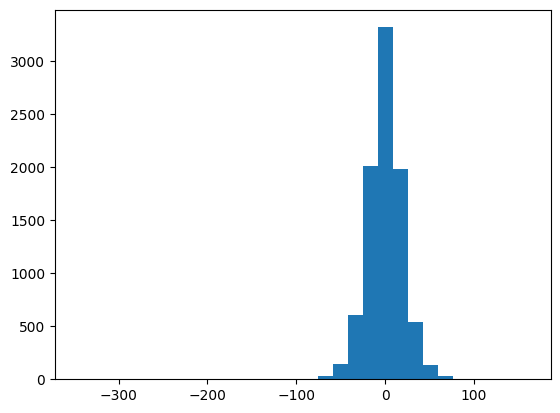

In [218]:
import matplotlib.pyplot as plt

#the distribution of the Bollinger Z-Scores (another safety check: if tails are too heavy, or distribution isn't centered, something is off)
plt.hist(all_signals['BTCUSDC/BTCUSDT'], bins=30)
plt.show()

7. Entrance

Signals above 1 std indicate that the deviation will revert within the day. The prediction coin is shorted, and the predicted coin is bought. The coin is held until the signal falls below 1. 

NOTE: raising the signal threshold will lower tcosts, but will lower sharpe.

In [219]:
all_weights = pd.DataFrame(index= cumret_train.index, columns=cumret_train.columns)

for crypto_pair in all_signals:
    crypto1, crypto2 = crypto_pair.split('/')
    signal_threshold = 30
    mask1 = all_signals[crypto_pair] > signal_threshold

    #all_weights.loc[mask1, crypto2] = (1/ (all_signals[mask1] > 1).sum(axis=1) / 2) * -1
    all_weights.loc[mask1, crypto1] = (1/ (all_signals[mask1] > signal_threshold).sum(axis=1)) 

all_weights = all_weights.dropna(axis=1, how='all').fillna(0)
all_weights.tail()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18279/2881900654.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_weights = all_weights.dropna(axis=1, how='all').fillna(0)


,BTCUSDC,ETHUSDC,SOLUSDC,ADAUSDC
2024-07-02 19:00:00,0.0,0.0,0.0,1.0
2024-07-02 20:00:00,0.5,0.0,0.0,0.5
2024-07-02 21:00:00,0.0,0.0,0.0,1.0
2024-07-02 22:00:00,0.0,0.0,0.0,1.0
2024-07-02 23:00:00,0.0,0.0,0.0,1.0


8. Trading Frequency

A table to show how often trades are entered

In [220]:
#how frequently i'm making trades
freq = all_weights.astype(bool).sum() / len(all_weights.columns)
freq 

BTCUSDC    127.25
ETHUSDC    146.00
SOLUSDC    151.75
ADAUSDC    141.75
dtype: float64

9. Returns

<Axes: >

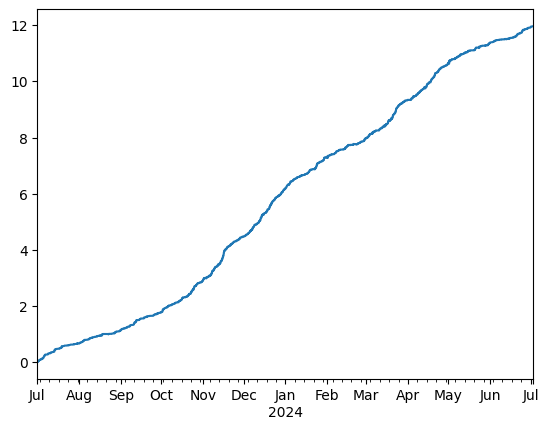

In [221]:
#fix: once we have our mulit-indexed dataframe of asset weights, we can get the sharpe of each strategy and output the mean, std, and sharpe into a table to display for the project
port_ret_train = (ret_train * all_weights.shift()).sum(1)

port_ret_train.cumsum().plot()

10. Beta and Alpha

Getting $SPY returns to calculate beta and alpha

In [222]:
import yfinance as yf

spy = yf.download("SPY", start="2022-07-01", end='2024-07-01')['Close']
spy_ret = spy.pct_change()

/var/folders/y9/8pflc5xs1h7_fk5pzvpdplqr0000gn/T/ipykernel_18279/3264780153.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2022-07-01", end='2024-07-01')['Close']
[*********************100%***********************]  1 of 1 completed


11. Performing Linear Regression

In [223]:
X = spy_ret[['SPY']].fillna(0)
X = sm.add_constant(X)


Y = pd.DataFrame({"returns": port_ret_train}).dropna()
X, Y = X.align(Y, join='inner', axis=0)
results = sm.OLS(Y[["returns"]], X).fit()
print(results.params)
print(results.tvalues)

const    0.001239
SPY     -0.037000
dtype: float64
const    3.495811
SPY     -0.735823
dtype: float64


12. Getting Beta and Alpha Contributions

In [224]:
beta_contr = results.params['SPY']*X['SPY']
prediction = results.params['SPY']*X['SPY'] + results.params['const']
alpha_contr = results.params['const'] + results.resid

13. Calculating turnover and returns net of trading costs

In [225]:
tcost = 20

turnover = (all_weights - all_weights.shift()).abs().sum(1)
net_ret =  port_ret_train.subtract(turnover*tcost*1e-4, fill_value=0)

14. Calculating drawdown duration maximum and performance summary for TRAINING SET

In [226]:
def ddd(port_ret):
    cumulative = port_ret_train.add(1).cumprod()
    peak = cumulative.cummax()
    underwater = cumulative < peak

    duration = pd.Series(0, index=port_ret_train.index)
    count = 0

    for i in range(len(port_ret_train)):
        if underwater.iloc[i]:
            count += 1
            duration.iloc[i] = count
        else:
            count = 0
            duration.iloc[i] = 0

    return duration


uncon_backtest_summary = {}
uncon_backtest_summary["mean"] = port_ret_train.mean() * 365
uncon_backtest_summary["std"] = port_ret_train.std() * np.sqrt(365)
uncon_backtest_summary["gross sharpe"] = port_ret_train.mean() / port_ret_train.std() * np.sqrt(365)
uncon_backtest_summary["net sharpe"] = net_ret.mean() / net_ret.std() * np.sqrt(365)
uncon_backtest_summary["max drawdown"] = ddd(port_ret_train).max()
uncon_backtest_summary["alpha"] = alpha_contr.mean()
uncon_backtest_summary["beta"] = beta_contr.mean()
uncon_backtest_summary = pd.Series(data=uncon_backtest_summary)
formatted_summary = uncon_backtest_summary.map(lambda x: f"{x:.6f}")
print(formatted_summary)

mean             0.494353
std              0.106911
gross sharpe     4.623980
net sharpe       2.530364
max drawdown    66.000000
alpha            0.001239
beta            -0.000033
dtype: object
